# Translation with a Single Input Image
This notebook calculates the metrics of FID and $L_1$ for the Pix2Pix, StarGAN and CollaGAN-1 models trained on the Larger dataset.

The images are translated from all source domains to all target domains. When the metrics are condensed, the values have been averaged over all target poses.


In [1]:
%matplotlib inline

In [2]:
import gc
import logging
from time import time

import logging_utils

from ModelProxy import Pix2PixModelProxy, StarGANModelProxy, CollaGANModelProxy

logging_utils.configure()

model_loaders = {
    'pix2pix': lambda: Pix2PixModelProxy('models/pix2pix'),
    # 'stargan': lambda: StarGANModelProxy('models/model-selection/stargan-network-and-sampler/paired/target-multi/network-both'), # went for sbgames'24 originally
    'stargan': lambda: StarGANModelProxy('models/stargan'),
    'collagan': lambda: CollaGANModelProxy('models/collagan'),
}

## Loads the Larger Dataset

These tests use the Larger dataset.


In [3]:
from dataset_utils import DatasetLoader
from image_utils import show_single_image, show_single_input_model_comparison


dataset_loader = DatasetLoader("all", "test", limit=None)


### Sanity Checks the Dataset

Uncomment the cell below to see a sample image from the dataset.

In [4]:
def show_dataset_image():
    back, left, front, right = next(iter(dataset_loader.dataset))
    show_single_image(front)
    
# show_dataset_image()

## Sanity Checking the Models

Uncomment to see some images generated by each model.


2024-06-26 15:49:51 INFO     Start >> Loading Pix2Pix model front-to-right
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "
2024-06-26 15:49:58 INFO     End   >> Loading Pix2Pix model front-to-right


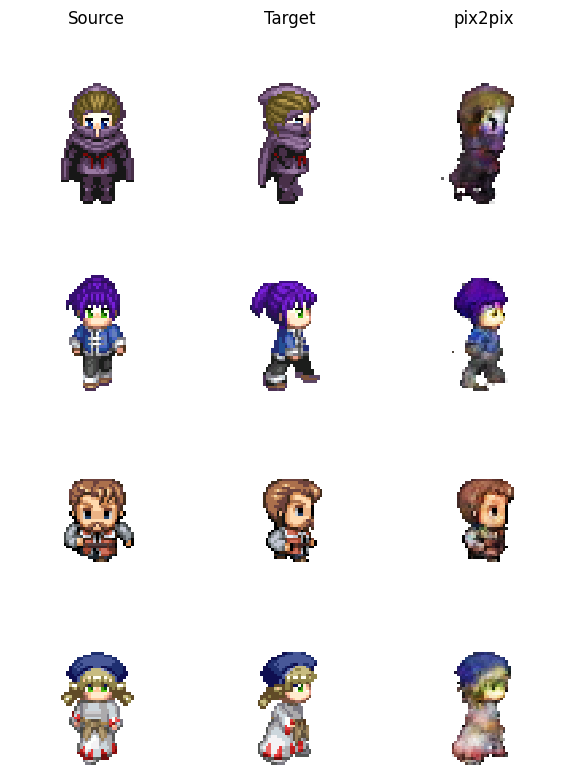

In [5]:
def generate_batch_with_each_model(source, target, quantity=4):
    # loads a batch of images
    batch = next(iter(dataset_loader.dataset.shuffle(600).batch(quantity).take(1)))

    source_images = batch[source]
    target_images = batch[target]
    genned_images = []    
    for model_name, model_loader in model_loaders.items():
        # loads the model into memory
        generator = model_loader()    
        # generates the images
        fake_images = generator.generate(source, target, batch)
        # shows the images
        genned_images += [fake_images]
        # frees the memory used by the model
        del generator

    show_single_input_model_comparison(source_images, target_images, genned_images, "", model_loaders.keys())

generate_batch_with_each_model(2, 3, 4)

## Running the Metrics Calculcation


In [6]:
from image_utils import show_single_input_model_matrix
import evaluation_metrics
import numpy as np


DOMAINS = ["back", "left", "front", "right"]

metrics = {
    model_name: {
        target_domain: {
            source_domain: [0, 0]
            for source_domain in DOMAINS}
        for target_domain in DOMAINS}
    for model_name in model_loaders.keys()
}


evaluation_metrics.preload()
model_matrices = []

for model_name, model_loader in model_loaders.items():
    model_start_time = time()
    logging.info(f"Start >> Using {model_name}")
    logging.info(f"Start >> Loading {model_name}")
    generator = model_loader()
    logging.info(f"End   >> Loading {model_name}")
    
    batch_size = 128 #16 if model_name == "pix2pix" else 128
    # sanity_check_sample = []  # [[back-from-back, back-from-left, ...], [left-from-back, left-from-left, ...], ...] 
    for t, target_domain in enumerate(DOMAINS):
        logging.debug(f"Start >> Processing {model_name} with target {target_domain.upper()}")
        # sanity_check_sample.append([])
        
        logging.debug(f"Start >> Calculating FID partial metrics for target {target_domain.upper()}")
        real_images = np.stack(list(dataset_loader.dataset))
        real_images = real_images[:, t]
        real_images_metrics = evaluation_metrics.calculate_metrics_for_dataset(real_images, batch_size)
        logging.debug(f"End   >> Calculating FID partial metrics for target {target_domain.upper()}")
        
        for s, source_domain in enumerate(DOMAINS):
            logging.info(f"Start >> Generating {model_name} images {source_domain}-to-{target_domain} ({t*len(DOMAINS)+s}/{len(DOMAINS) ** 2})")
            
            fake_images = []
            batched_dataset = dataset_loader.dataset.batch(32)
            for batch_number, batch in batched_dataset.enumerate():
                logging.debug(f"Start >> Generating {model_name} batch {batch_number}")
                generated_images = generator.generate(s, t, batch)
                fake_images.append(generated_images.numpy())
                logging.debug(f"End   >> Generating {model_name} batch {batch_number}")                
            logging.debug(f"End   >> Generating {model_name} images {source_domain}-to-{target_domain}")

            logging.debug(f"Start >> Calculating {model_name} metrics with {source_domain}-to-{target_domain}")
            fake_images = np.concatenate(fake_images, axis=0)
            fake_images_metrics = evaluation_metrics.calculate_metrics_for_dataset(fake_images, batch_size)
            # sanity_check_sample[t].append(fake_images[0])
            fid = evaluation_metrics.calculate_fid(real_images_metrics, fake_images_metrics)
            l1 = evaluation_metrics.calculate_l1(real_images, fake_images).numpy()
            metrics[model_name][target_domain][source_domain] = [fid, l1]
            logging.info(f"End   >> Calculating {model_name} metrics with {source_domain}-to-{target_domain}  ({t*len(DOMAINS)+s+1}/{len(DOMAINS) ** 2})")
        
        logging.debug(f"End   >> Processing {model_name} with target {target_domain.upper()}")
        
        # tries to free the memory used by the current target domain
        del real_images
        del real_images_metrics
        gc.collect()
            
    logging.info(f"End   >> Using {model_name}")
    logging.info(f"Time  >> {model_name} took {time() - model_start_time} seconds")
    
    # logging.info(f"Start >> Showing {model_name} sample translation matrix")
    # model_matrix_image = show_single_input_model_matrix(sanity_check_sample, model_name)
    # model_matrices.append(model_matrix_image)
    # logging.info(f"End   >> Showing {model_name} sample translation matrix")

    # tries to free the memory used by the current model, as we're going to load another one
    del generator
    gc.collect()

for model_matrix in model_matrices:
    model_matrix.show()

2024-06-26 15:50:05 INFO     Start >> Loading InceptionV3 model...
2024-06-26 15:50:08 INFO     End   >> Loading InceptionV3 model.
2024-06-26 15:50:08 INFO     Start >> Using pix2pix
2024-06-26 15:50:08 INFO     Start >> Loading pix2pix
2024-06-26 15:50:08 INFO     End   >> Loading pix2pix
2024-06-26 15:50:47 INFO     Start >> Generating pix2pix images back-to-back (0/16)
2024-06-26 15:50:48 INFO     Start >> Loading Pix2Pix model back-to-back
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "
2024-06-26 15:50:53 INFO     End   >> Loading Pix2Pix model back-to-back
2024-06-26 15:51:31 

## Displays the Results and Saves to Excel

In [7]:
import pandas as pd
df = pd.DataFrame(columns=["Model", "Source", "Target", "FID", "L1"])
for model_name, model_metrics in metrics.items():
    for target_domain, source_metrics in model_metrics.items():
        for source_domain, values in source_metrics.items():
            df = df.append({
                "Model": model_name,
                "Target": target_domain,
                "Source": source_domain,
                "FID": values[0],
                "L1": values[1]
            }, ignore_index=True)
            
df

,Model,Source,Target,FID,L1
0,pix2pix,back,back,0.010424,0.000757
1,pix2pix,left,back,6.756772,0.058875
2,pix2pix,front,back,3.009540,0.043955
3,pix2pix,right,back,7.570261,0.059264
4,pix2pix,back,left,3.589222,0.065179
5,pix2pix,left,left,0.003150,0.000733
6,pix2pix,front,left,2.669112,0.057806
7,pix2pix,right,left,0.902761,0.025122
8,pix2pix,back,front,4.182349,0.052416
9,pix2pix,left,front,5.643492,0.061592


In [8]:
from datetime import datetime

today = datetime.today().strftime("%d-%m-%Y")
df.apply(pd.to_numeric, errors="ignore")
df.to_excel(f"output/single-input-metrics-{today}.xlsx", index=False)